# ECCITE 1D Analysis

In [15]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [16]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 500)

In [17]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [18]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [19]:
data_path = '/data_volume/memento/eccite/'

### 

In [86]:
b = pd.read_csv(data_path + 'raw/GSM4633616_ECCITE_HTO_counts.tsv', sep='\t', index_col=0).T

In [87]:
b.shape

(20729, 12)

In [88]:
adata.obs.head(5)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nFeature_GDO,nCount_ADT,nFeature_ADT,percent.mito,MULTI_ID,MULTI_classification,MULTI_classification.global,HTO_classification,guide_ID,guide_ID.global,gene,con,NT,crispr,replicate,S.Score,G2M.Score,Phase
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99,4,576,111,801,4,2.295577,rep1-tx,rep1-tx,rep1-tx,rep1-tx,STAT2g2,Singlet,STAT2,tx,STAT2g2,Perturbed,rep1,-0.252716,-0.771309,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35,5,190,111,545,4,4.512939,rep1-tx,rep1-tx,rep1-tx,rep1-tx,CAV1g4,Singlet,CAV1,tx,CAV1g4,Perturbed,rep1,-0.123802,-0.332603,G1
l1_AAACCTGCATGAGCGA,Lane1,15256,4258,66,4,212,111,344,4,4.116413,rep1-tx,rep1-tx,rep1-tx,rep1-tx,STAT1g2,Singlet,STAT1,tx,STAT1g2,Perturbed,rep1,-0.154633,-0.694418,G1
l1_AAACCTGTCTTGTCAT,Lane1,5135,1780,22,3,243,111,539,4,5.491723,rep1-tx,rep1-tx,rep1-tx,rep1-tx,CD86g1,Singlet,CD86,tx,CD86g1,Perturbed,rep1,-0.061262,-0.037820,G1
l1_AAACGGGAGAACAACT,Lane1,9673,2671,99,5,198,111,1053,4,3.359868,rep1-tx,rep1-tx,rep1-tx,rep1-tx,IRF7g2,Singlet,IRF7,tx,IRF7g2,Perturbed,rep1,-0.132188,-0.353156,G1


In [92]:
num_genes

matrix([[3942],
        [2948],
        [4258],
        ...,
        [4185],
        [3204],
        [5073]])

In [89]:
num_genes = (adata.X > 0).sum(axis=1)

In [91]:
num_genes.min()

1039

In [77]:
b.shape

(0, 7)

In [40]:
def seurat_clr(x):
    # TODO: support sparseness
    s = np.sum(np.log1p(x[x > 0]))
    exp = np.exp(s / len(x))
    return np.log1p(x / exp)

In [41]:
b_norm = seurat_clr(b)

In [44]:
from sklearn.decomposition import PCA 

In [46]:
pca = PCA(n_components=2).fit_transform(b_norm)

In [73]:
adata.obs['con'].value_counts()

tx    20729
Name: con, dtype: int64

In [69]:
rep1_cells = adata.obs.query('replicate == "rep1"').index.tolist()

In [54]:
adata_HTO = sc.AnnData(X=b_norm.values, obs=pd.DataFrame(b_norm[[]]), var=pd.DataFrame(b_norm.T[[]]))

In [63]:
sc.tl.pca(adata_HTO, svd_solver='arpack')
sc.pp.neighbors(adata_HTO, n_neighbors=50, n_pcs=40)
sc.tl.umap(adata_HTO)


In [56]:
adata_HTO.obs

""
l1_AAACCTGAGCCAGAAC
l1_AAACCTGAGTGGACGT
l1_AAACCTGCATGAGCGA
l1_AAACCTGTCTTGTCAT
l1_AAACGGGAGAACAACT
...
l8_TTTGTCAGTCACTTCC
l8_TTTGTCAGTGACGGTA
l8_TTTGTCAGTTCCACAA
l8_TTTGTCATCACGCATA


In [47]:
pca

array([[ 2.64187821,  0.10041156],
       [ 1.88445849,  0.03593454],
       [ 2.18884219,  0.06312652],
       ...,
       [-1.9155588 , -1.3034987 ],
       [-1.76406494, -1.43728103],
       [-1.72941013, -1.16011685]])

In [42]:
b_norm

,rep1-tx,rep1-ctrl,rep2-tx,rep2-ctrl,PDL1g1-tx,PDL1g1-ctrl,PDL1g2-tx,PDL1g2-ctrl,rep3-tx,rep3-ctrl,rep4-tx,rep4-ctrl
l1_AAACCTGAGCCAGAAC,2.774109,1.153355,1.725041,0.563772,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
l1_AAACCTGAGTGGACGT,1.458156,0.544030,1.589867,1.393557,0.667406,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
l1_AAACCTGCATGAGCGA,2.404898,1.358857,1.140702,0.000000,0.000000,0.000000,0.00000,0.643743,0.000000,0.000000,0.000000,0.000000
l1_AAACCTGTCTTGTCAT,1.271201,0.000000,1.140702,0.000000,0.000000,1.016180,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
l1_AAACGGGAGAACAACT,2.785478,0.000000,1.725041,0.563772,0.667406,0.631968,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
l8_TTTGTCAGTCACTTCC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.746215,1.220410,1.117832,1.213833
l8_TTTGTCAGTGACGGTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.724851,0.585669,4.217920,0.000000
l8_TTTGTCAGTTCCACAA,0.000000,0.000000,0.000000,0.000000,0.000000,0.631968,1.07896,0.643743,3.011196,0.585669,1.342878,0.000000
l8_TTTGTCATCACGCATA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.925257,0.585669,1.074859,0.000000


In [27]:
b.shape

(20729, 12)

<AxesSubplot:xlabel='rep1-tx', ylabel='Density'>

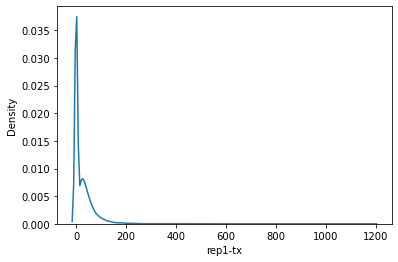

In [38]:
sns.kdeplot(b['rep1-tx'])

In [37]:
b[b['rep2-ctrl'] > 5]

,rep1-tx,rep1-ctrl,rep2-tx,rep2-ctrl,PDL1g1-tx,PDL1g1-ctrl,PDL1g2-tx,PDL1g2-ctrl,rep3-tx,rep3-ctrl,rep4-tx,rep4-ctrl
l1_ACGAGGAAGTACGCGA,65,0,6,6,0,0,0,1,0,0,0,0
l1_AGCGGTCCATTGAGCT,13,0,5,8,0,0,0,0,0,0,0,0
l1_ATCCACCTCGTCTGCT,78,1,16,7,0,0,0,0,0,0,0,0
l1_ATCTACTCACGACTCG,84,1,12,6,0,0,0,0,0,0,0,0
l1_CACAGGCCACGCGAAA,69,2,14,7,0,0,0,2,0,0,0,0
l1_CACCACTCACTAAGTC,153,1,12,6,0,0,0,0,0,0,0,0
l1_CAGTCCTAGTCGATAA,235,1,16,7,0,0,0,0,0,0,0,0
l1_CATGCCTGTCCAGTAT,73,3,14,8,1,0,1,0,0,0,0,0
l1_CCACGGAAGGTTCCTA,71,1,16,6,0,1,1,1,0,0,0,0
l1_CCTTCCCGTTGATTCG,15,2,16,6,0,0,0,0,0,0,0,0


In [33]:
adata.obs.shape

(20729, 24)

In [35]:
b.shape

(20729, 12)

### Read the guide labled perturb-seq data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'eccite.h5ad')
adata.var.index.name=None

In [7]:
adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nFeature_GDO,nCount_ADT,nFeature_ADT,percent.mito,MULTI_ID,MULTI_classification,MULTI_classification.global,HTO_classification,guide_ID,guide_ID.global,gene,con,NT,crispr,replicate,S.Score,G2M.Score,Phase
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99,4,576,111,801,4,2.295577,rep1-tx,rep1-tx,rep1-tx,rep1-tx,STAT2g2,Singlet,STAT2,tx,STAT2g2,Perturbed,rep1,-0.252716,-0.771309,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35,5,190,111,545,4,4.512939,rep1-tx,rep1-tx,rep1-tx,rep1-tx,CAV1g4,Singlet,CAV1,tx,CAV1g4,Perturbed,rep1,-0.123802,-0.332603,G1


In [8]:
adata.obs['con'].value_counts()

tx    20729
Name: con, dtype: int64

In [9]:
df = pd.read_csv(data_path + 'GSE153056_ECCITE_metadata.tsv', sep='\t')

In [10]:
df['con'].value_counts()

tx    20729
Name: con, dtype: int64

In [11]:
# guides = adata.obs.guides.drop_duplicates().tolist()
# guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
# ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

In [14]:
adata.shape

(20729, 18649)

In [12]:
adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nFeature_GDO,nCount_ADT,nFeature_ADT,percent.mito,MULTI_ID,MULTI_classification,MULTI_classification.global,HTO_classification,guide_ID,guide_ID.global,gene,con,NT,crispr,replicate,S.Score,G2M.Score,Phase
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99,4,576,111,801,4,2.295577,rep1-tx,rep1-tx,rep1-tx,rep1-tx,STAT2g2,Singlet,STAT2,tx,STAT2g2,Perturbed,rep1,-0.252716,-0.771309,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35,5,190,111,545,4,4.512939,rep1-tx,rep1-tx,rep1-tx,rep1-tx,CAV1g4,Singlet,CAV1,tx,CAV1g4,Perturbed,rep1,-0.123802,-0.332603,G1


In [13]:
adata.obs['HTO_classification'].value_counts()

rep1-tx    9428
rep3-tx    6001
rep2-tx    5300
Name: HTO_classification, dtype: int64

### Setup memento

In [88]:
adata.obs['q'] = 0.2

In [89]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.05)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned
  all_res_var = estimator._residual_variance(all_m, all_v, estimator._fit_mv_regressor(all_m, all_v))


In [90]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Memento

In [ ]:
for g in ko_genes:
    
    if g == 'NT':
        continue
        
    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()
    
    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values
    
    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])
    
    memento.compute_1d_moments(subset, min_perc_group=.7)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_ko + replicate',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        resampling='bootstrap',
        approx=False,
        num_cpus=94)
    
    subset.write(data_path + '1d/{}_guides_rep.h5ad'.format(g)) 


### Analyze 1D

In [ ]:
results = {}
for g in ko_genes:
#     print(g)
    if g == 'NT': continue
    subset = sc.read(data_path +'1d/{}_guides_rep.h5ad'.format(g))
    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    results[g] = df.copy()

In [ ]:
results['STAT1'].query('gene == "STAT1"')

In [ ]:
# for g in ko_genes:
#     print(g, results[g].query('de_fdr < 0.1').shape[0],results[g].query('dv_fdr < 0.1').shape[0])

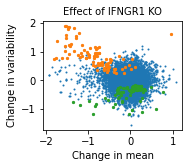

In [132]:
tf = 'IFNGR1'
plt.figure(figsize=(2.5,2))
plt.scatter(results[tf]['de_coef'], results[tf]['dv_coef'], s=1)
plt.title('Effect of {} KO'.format(tf));
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=5)
plt.scatter(results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['de_coef'], results[tf].query('dv_fdr < 0.1 & dv_coef < 0')['dv_coef'], s=5)

# plt.savefig('figures/variability_{}.png'.format(tf), bbox_inches='tight', dpi=800)

In [ ]:
plt.figure(figsize=(2.5,2))
plt.scatter(results['STAT1']['de_coef'], results['STAT1']['dv_coef'], s=0.1)
plt.title('Effect of STAT1 KO');
plt.xlabel('Change in mean'); plt.ylabel('Change in variability')
plt.scatter(results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['de_coef'], results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0')['dv_coef'], s=1)
# plt.savefig('figures/variability.png', bbox_inches='tight', dpi=800)

In [134]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


### Run coexpression

In [ ]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ko_genes:
    
    for g_ko in ko_genes:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO.h5ad'.format(g, g_ko)
#         if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko])].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values

        memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue

        available_genes = list(
            set(subset.var.index) & \
            set(results[g].query('de_coef < 0 & de_fdr < 0.1').gene.tolist()) & \
            set(results[g_ko].query('de_coef < 0 & de_fdr < 0.1').gene.tolist())
            )
        
        if len(available_genes) < 10: continue
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='bootstrap',
            approx=False)
        
        subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g_ko))

### Check TF's correlation to other genes following KO

In [123]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ['JAK2']:#ko_genes:
    
    if g == 'NT': continue
    fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g)
#         if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_genes = list(set(subset.var.index))

    if len(available_genes) < 10: continue
    memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

#     memento.ht_2d_moments( 
#         subset, 
#         formula_like='1 + is_ko + replicate',
#         treatment_col='is_ko', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)

#     subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))


In [124]:
moments, counts = memento.get_2d_moments(subset)

In [131]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


In [127]:
dv_genes = results['JAK2'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [128]:
moments.query('gene_2 in @dv_genes')

,gene_1,gene_2,sg^False^rep1^NTg1,sg^True^rep1^JAK2g2,sg^False^rep1^NTg4,sg^True^rep1^JAK2g3,sg^False^rep1^NTg5,sg^False^rep1^NTg8,sg^True^rep1^JAK2g1,sg^False^rep1^NTg9,sg^False^rep1^NTg2,sg^False^rep1^NTg10,sg^False^rep1^NTg7,sg^True^rep1^JAK2g4,sg^False^rep1^NTg3,sg^False^rep3^NTg1,sg^False^rep3^NTg7,sg^False^rep3^NTg9,sg^False^rep3^NTg3,sg^False^rep2^NTg4,sg^False^rep2^NTg9,sg^False^rep3^NTg4,sg^True^rep2^JAK2g1,sg^True^rep2^JAK2g2,sg^False^rep3^NTg2,sg^True^rep3^JAK2g2,sg^False^rep2^NTg3,sg^True^rep2^JAK2g4,sg^False^rep2^NTg1,sg^False^rep3^NTg10,sg^True^rep3^JAK2g1,sg^True^rep3^JAK2g3,sg^False^rep2^NTg7,sg^False^rep2^NTg5,sg^True^rep3^JAK2g4,sg^False^rep3^NTg5,sg^False^rep3^NTg8,sg^True^rep2^JAK2g3,sg^False^rep2^NTg10,sg^False^rep2^NTg2,sg^False^rep2^NTg8
125,JAK2,HLA-C,-0.015622,0.383648,0.223251,0.430683,0.002418,NaN,0.523401,0.261606,0.449962,0.258368,0.097659,0.500171,-0.035229,0.198901,0.296942,0.395915,0.356074,0.131028,0.288232,0.030565,0.385418,0.497647,0.520283,0.697198,0.144406,0.407563,0.393997,0.173433,0.583956,0.500657,0.188711,0.165210,0.632604,0.267701,0.190398,0.093159,0.295714,-0.152013,0.361794
172,JAK2,RNF213,0.577183,0.516582,0.546090,0.701608,0.346827,NaN,0.271322,0.627981,0.289081,0.410681,0.405114,0.629261,0.641741,0.475079,0.370747,0.390878,0.787863,0.606816,0.715695,0.473883,0.863869,0.807826,0.776315,0.903610,0.617997,0.609559,0.613145,0.569366,0.675220,0.928082,0.562320,0.749917,0.477279,0.480784,-0.128616,0.527344,0.551202,0.672386,0.390886
353,JAK2,PSME2,0.146101,0.573440,0.029479,0.824346,0.157631,0.134588,0.536283,0.066725,-0.032511,0.212813,0.016199,0.781385,-0.130147,-0.024255,0.124101,0.047436,0.294102,0.024681,0.178850,0.136705,0.619635,0.644324,0.563637,0.597621,-0.255713,0.633636,0.350985,0.343628,0.698132,0.555557,0.149822,0.066141,0.747074,-0.059176,-0.064034,0.295141,0.168783,-0.235117,0.252750
403,JAK2,GSDMD,0.422489,0.583662,0.332015,0.790820,0.204026,NaN,0.470228,-0.144746,0.099381,0.128417,0.157289,0.751296,-0.091610,0.271934,0.273356,0.545491,0.333387,0.395886,0.039547,0.036379,0.795801,0.720090,0.153374,0.698034,0.268604,0.639489,0.301339,0.270857,0.858229,0.704514,0.053542,0.165385,0.880568,0.084464,0.273105,0.455422,0.549721,0.562582,0.637719
461,JAK2,GBP1,0.076778,0.988292,0.582542,0.969392,0.323408,0.992585,0.586704,0.710294,0.727063,0.723329,0.539108,NaN,0.411632,0.474010,0.552666,0.596094,0.498794,0.583651,0.240410,0.292173,0.840702,0.842487,0.566572,0.920233,0.617487,0.787451,0.522834,0.581623,0.663552,NaN,0.572722,0.641588,0.882341,0.280832,0.374804,0.392450,0.568412,0.352389,0.362473
639,JAK2,TULP4,-0.000904,-0.089653,-0.105124,0.035769,0.120398,NaN,0.061012,0.228246,0.165139,0.836671,-0.052015,-0.230264,-0.116764,0.182471,-0.194179,0.151273,NaN,0.667554,-0.291103,-0.282228,-0.022282,0.306546,NaN,0.382403,0.561529,-0.075614,-0.376227,-0.440652,0.089422,-0.453079,0.529410,-0.331620,-0.377696,0.124731,-0.201225,0.125208,-0.175435,NaN,-0.183682
700,JAK2,IFITM3,0.079186,0.095008,0.277336,0.512240,0.134556,NaN,0.398447,0.478140,0.467559,0.375284,0.299405,0.783966,-0.040751,0.399245,0.175586,0.123413,0.356540,0.450961,0.166878,0.213286,0.567487,0.483959,0.601320,0.544228,0.444984,0.297801,0.545237,0.409694,0.496912,0.605454,0.192498,0.309844,0.274875,0.008538,0.225419,0.359768,0.366044,0.280328,0.383327
748,JAK2,FCGR1B,0.211132,0.599530,0.338313,0.831620,-0.120004,NaN,0.580725,-0.345870,0.097664,0.072005,0.211489,0.325249,-0.155655,0.349228,0.200802,0.470351,-0.009079,0.500300,0.000778,0.320791,0.655648,0.854509,0.741396,0.683033,0.052496,0.785777,0.534034,0.304703,0.721135,0.910993,0.422196,0.055919,0.988267,-0.126419,0.252789,0.583473,0.539163,0.300029,0.310199
797,JAK2,HLA-B,0.097557,0.578303,0.289019,0.730769,0.098013,NaN,0.405711,0.386238,0.092323,0.534929,0.147288,0.424225,-0.102929,0.180936,0.372703,0.449561,0.453250,0.335664,0.161392,0.157667,0.455872,0.621355,0.735340,0.599161,0.265036,0.483101,0.277912,0.415036,0.442836,0.486009,0.301310,0.347429,0.799136,0.133251

In [120]:
subset.obs['STAT1'] = subset[:, 'STAT1'].X.todense().A1
subset.obs['GBP4'] = subset[:, 'GBP4'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [121]:
smf.glm('GBP4 ~ STAT1 * is_ko', data=subset.obs.query('replicate=="rep2"'), family=sm.families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   GBP4   No. Observations:                  754
Model:                            GLM   Df Residuals:                      750
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2077.3
Date:                Thu, 28 Oct 2021   Deviance:                       1959.4
Time:                        14:33:33   Pearson chi2:                 2.15e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.1317      0.030     37.232      0.000       1.072       1.191
is_ko[T.True]          -1.2011      0.115    -10.471      0.000      -1.426      -0.976
STAT1                   0.0357      0.001     24.003      0.000       0.033       0.039
STAT1:is_ko[T.True]     0.0488      0.007      6.563      0.000       0.034       0.063
=======================================================================================
"""

In [70]:
dv_genes = results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [71]:
moments.query('gene_2 in @dv_genes')

,gene_1,gene_2,sg^True^rep1^STAT1g2,sg^False^rep1^NTg1,sg^False^rep1^NTg4,sg^False^rep1^NTg5,sg^True^rep1^STAT1g3,sg^False^rep1^NTg8,sg^False^rep1^NTg9,sg^False^rep1^NTg2,sg^False^rep1^NTg10,sg^False^rep1^NTg7,sg^True^rep1^STAT1g1,sg^False^rep1^NTg3,sg^True^rep1^STAT1g4,sg^False^rep3^NTg1,sg^True^rep2^STAT1g1,sg^False^rep3^NTg7,sg^True^rep3^STAT1g3,sg^False^rep3^NTg9,sg^False^rep3^NTg3,sg^False^rep2^NTg4,sg^False^rep2^NTg9,sg^False^rep3^NTg4,sg^False^rep3^NTg2,sg^True^rep3^STAT1g2,sg^False^rep2^NTg3,sg^False^rep2^NTg1,sg^False^rep3^NTg10,sg^False^rep2^NTg7,sg^False^rep2^NTg5,sg^False^rep3^NTg5,sg^False^rep3^NTg8,sg^False^rep2^NTg10,sg^True^rep2^STAT1g3,sg^False^rep2^NTg2,sg^True^rep2^STAT1g4,sg^True^rep3^STAT1g1,sg^False^rep2^NTg8,sg^True^rep2^STAT1g2,sg^True^rep3^STAT1g4
109,STAT1,RNF213,0.995005,0.356013,0.643242,0.275576,0.819006,NaN,0.510899,0.649369,0.064293,0.406013,0.951399,0.440901,NaN,0.322210,0.543910,0.314070,0.816895,0.537478,0.758088,0.661580,0.610646,0.323238,0.294089,0.730903,0.344220,0.594915,0.531644,0.447140,0.562024,0.669664,0.514593,0.439295,0.735132,0.112062,NaN,0.845324,0.719524,NaN,0.792395
244,STAT1,PSME2,0.649440,0.377717,0.200542,0.229040,0.671293,0.075856,0.063773,0.068332,0.310274,0.304829,0.965094,0.348018,NaN,0.207993,NaN,0.308721,0.697362,0.190212,0.306434,0.379560,0.204707,0.410223,0.302492,0.937803,0.344960,0.202323,0.311615,0.234329,0.372005,0.640963,0.301571,-0.022674,0.619267,0.130799,NaN,NaN,0.429363,0.835583,-0.002368
274,STAT1,GSDMD,0.626319,0.363190,0.304682,0.321261,0.582191,NaN,0.161575,-0.012827,0.258730,0.187687,0.960483,0.420578,NaN,0.175197,NaN,0.474363,0.820846,0.145544,0.325681,0.522269,0.183361,0.337823,-0.060176,0.948309,0.227326,0.127882,0.425834,-0.026011,0.180068,0.246025,0.147624,0.432094,0.921657,0.713677,NaN,0.829420,0.531795,NaN,NaN
312,STAT1,GBP1,0.897573,0.408235,0.559140,0.515823,0.655702,0.317666,0.294541,0.529180,0.269166,0.321876,NaN,0.426478,NaN,0.689505,NaN,0.407472,0.844168,0.536743,0.501596,0.576181,0.330156,0.340282,0.074588,0.722290,0.209975,0.466028,0.579275,0.425285,0.327030,0.671875,0.794768,0.608339,0.961695,-0.084757,0.992070,0.662225,0.412075,NaN,0.590918
480,STAT1,IFITM3,0.942364,0.321158,0.402825,0.157291,0.731070,NaN,0.439110,0.460551,0.314582,0.426453,NaN,0.102204,NaN,0.244534,NaN,0.218581,0.569426,0.087651,0.369266,0.667060,0.241151,0.301109,-0.070233,0.863052,0.158776,0.442873,0.186001,0.228801,0.281702,0.447291,0.319919,0.086747,0.747211,0.176162,NaN,0.343356,0.571361,0.673427,-0.262823
505,STAT1,FCGR1B,0.823636,0.094049,0.259089,0.332306,0.703070,-0.368869,0.275249,-0.028657,0.274527,0.473115,NaN,-0.195240,NaN,0.371628,NaN,0.259837,0.895282,0.225071,0.018766,0.483272,0.227249,0.358873,0.110492,0.686185,0.343801,0.122211,0.274865,0.185501,0.474959,0.284739,0.267296,0.237624,0.862224,0.353561,NaN,NaN,0.505419,0.646332,0.372158
531,STAT1,OAS2,NaN,0.312649,0.200128,0.580315,0.767427,0.759854,-0.030618,0.768857,0.559810,0.350856,NaN,0.515644,NaN,0.253918,0.644132,0.480358,0.628912,-0.015641,0.193778,0.351637,0.414336,-0.065163,0.700994,NaN,0.512530,-0.170365,0.477366,0.028314,0.754461,0.204391,0.077499,0.082825,0.258566,0.995218,NaN,NaN,NaN,-0.293233,-0.010048
554,STAT1,CMPK2,NaN,0.392404,0.493639,0.634237,0.709276,-0.205675,0.379237,0.460675,-0.135437,0.327749,NaN,-0.038664,NaN,0.102085,NaN,0.237652,0.207271,0.076901,0.234764,0.078515,0.288557,0.041790,-0.208298,0.716037,0.227577,0.167872,0.296557,0.150089,0.556486,0.096640,0.542447,0.183528,0.782620,0.329229,0.551342,0.854074,NaN,NaN,-0.629367
718,STAT1,TMSB10,0.686497,0.179831,0.233184,0.182891,0.591913,NaN,0.174191,0.208834,0.191914,0.238936,0.937792,-0.005703,NaN,-0.045496,0.760719,0.263762,0.524268,0.308516,0.371870,0.336960,0.173252,0.140645,-0.135351,0.531754,0.124772,0.281554,0.431646,0.369364,0.295832,0.294016,0.470622,0.426485,0.836592,0.211942,0.761870,0.506713,0.330401,0.495985,0.753263
753,STAT1,IRF7,0.842978,0.331056,0.314508,0.451522,0.752801,NaN,0.146692,0.142767,0.010024,0.179576,0.

In [72]:
df.query('gene_2 in @dv_genes')

UndefinedVariableError: name 'gene_2' is not defined

In [ ]:
df = memento.get_2d_ht_result(subset)

In [ ]:
results['STAT1'].query('gene == "STAT1"')

### Debugging
